In [352]:
import os
import random
import re
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.feature import hog
from PIL import Image


Используя набор данных data, сгенерируйте последовательность символов вида
наличие/отсутствие открывающейся скобки, число/буква, знак операции,
число/буква, наличие/отсутствие закрывающейся скобки

In [124]:
def generate_expression(
    digits = ['0','1','2','3','4','5','6','7','8','9'],
    letters = ['h','w','X','y'],
    operations = ['+','-','times'],
):
    answer = []
    left = random.choice(digits + letters)
    op = random.choice(operations)
    right = random.choice(digits + letters)
    
    answer.append(left)
    answer.append(op)
    answer.append(right)
    
    if random.choice([True, False]):
        answer.insert(0, '(')
    if random.choice([True, False]):
        answer.append(')')
    
    return answer

for _ in range(5):
    answer = generate_expression()
    print(''.join(answer))

(7+9)
(w-6)
3times0
(6+4
(3-4


# b. Символы соответствую классам данных архива data.
# c. На основе сгененированной последовательности создайте последовательность изображений символов, где каждому символу соотвествует случайное изображение набора данных соотвествующего класса.

In [351]:
def get_random_image(folder_name):
    """Получает случайное изображение из указанной папки"""
    folder_path = os.path.join(os.path.abspath('.'), 'data', folder_name)
    if not os.path.exists(folder_path):
        raise ValueError(f"Папка {folder_path} не существует")
    
    images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        raise ValueError(f"В папке {folder_path} нет изображений")
    
    random_image = random.choice(images)
    return Image.open(os.path.join(folder_path, random_image))

Сгенерированное выражение: htimesy


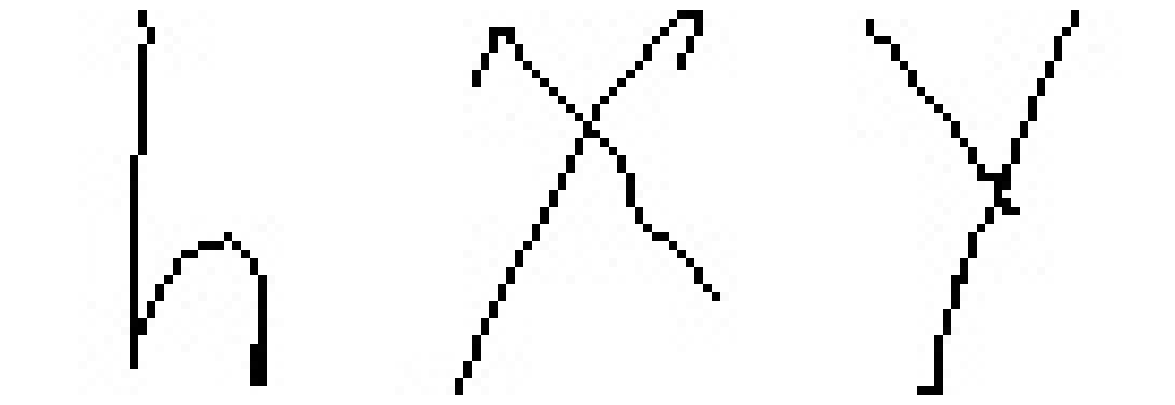

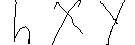

In [280]:
def generate_expression_with_images(answer, save_path=None):
    images = [get_random_image(sym) for sym in answer]
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)
    combined_image = Image.new('RGB', (total_width, max_height), 'white')
    x_offset = 0
    for img in images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width
    # Показываем результат
    plt.figure(figsize=(15,5))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.show()
    # Сохраняем изображение, если указан путь
    if save_path:
        combined_image.save(save_path)
        print(f"Изображение сохранено в {save_path}")
    
    return combined_image

expr = generate_expression()
print(f"Сгенерированное выражение: {''.join(expr)}")
generate_expression_with_images(expr)

# d. Обучите метод knn для обучающей последовательности. Для обучающей выборки выберите 10-20 изображений каждого класса.


In [281]:


def load_images_from_folder_hog(folder_path, label, limit=20, size=(45, 45)):
    images = []
    files = os.listdir(folder_path)
    random.shuffle(files)
    files = [f for f in files if f.endswith('.jpg')][:limit]

    for fname in files:
        path = os.path.join(folder_path, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, size)
        
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        images.append((features, label))
    return images

def prepare_training_data_hog(data_root="data", limit_per_class=20):
    all_data = []
    for label in os.listdir(data_root):
        folder_path = os.path.join(data_root, label)
        if os.path.isdir(folder_path):
            samples = load_images_from_folder_hog(folder_path, label, limit=limit_per_class)
            all_data.extend(samples)

    X = np.array([x for x, _ in all_data])
    y = np.array([y for _, y in all_data])
    return X, y


def train_knn_classifier(X, y, n_neighbors=3):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(X, y)
    # acc = knn.score(X, y)
    # print(f"Точность на отложенной выборке: {acc:.3f}")
    return knn


X_hog, y_hog = prepare_training_data_hog(data_root="data", limit_per_class=20)

# [train_knn_classifier(X_hog, y_hog, n_neighbors=x) for x in range(1,21)]

knn_hog = train_knn_classifier(X_hog, y_hog, n_neighbors=3)
acc = knn_hog.score(X_hog, y_hog)
print(f"Точность на отложенной выборке: {acc:.3f}")

Точность на отложенной выборке: 0.798


# e. Выполните классификацию последовательности символов шага с.

Сгенерированное выражение: 7times3


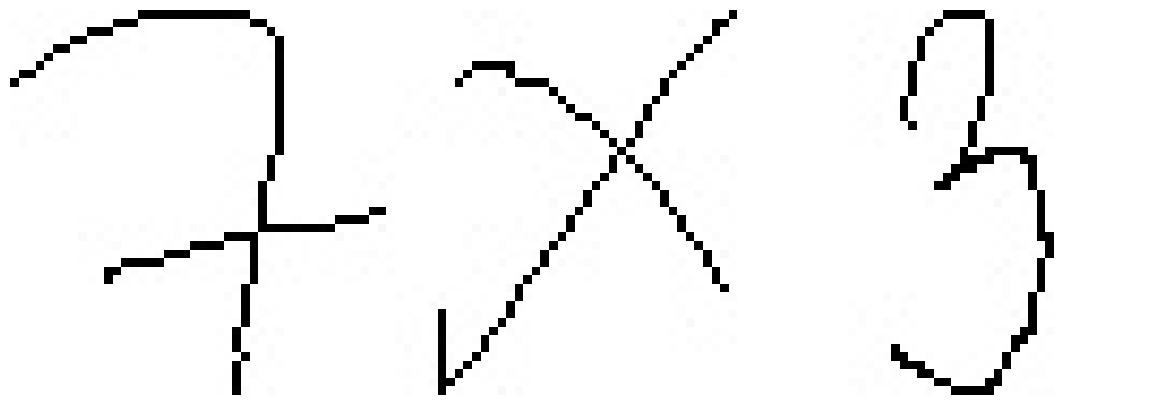

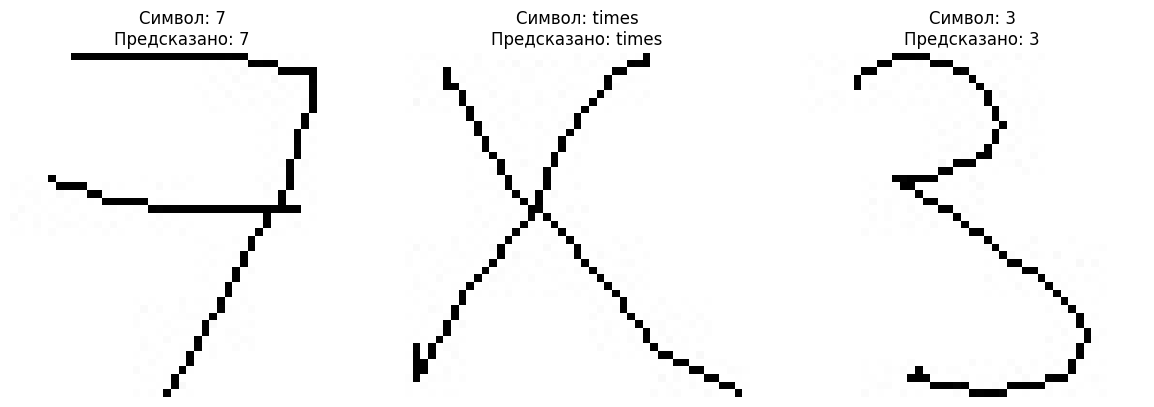

Распознанное выражение: 7times3


In [287]:
def classify_symbol_image_hog(knn_model, img, size=(45, 45)):
    # Конвертируем PIL Image в numpy array
    img_np = np.array(img)
    # Конвертируем в градации серого, если изображение цветное
    if len(img_np.shape) == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    img_resized = cv2.resize(img_np, size)
    features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    features = features.reshape(1, -1)
    pred = knn_model.predict(features)
    return pred[0]

def classify_expression_image(knn_model, expression):
    symbols = expression
    predicted = []
    images = []  # Список для хранения изображений
    labels = []  # Список для хранения меток

    for symbol in symbols:
        try:
            # Получаем случайное изображение для символа
            img = get_random_image(symbol)
            # Классифицируем изображение
            label = classify_symbol_image_hog(knn_model, img)
            predicted.append(label)
            
            # Сохраняем изображение и метки
            images.append(np.array(img))
            labels.append((symbol, label))
            
        except ValueError as e:
            print(f"Ошибка для символа {symbol}: {str(e)}")
            predicted.append('?')
            continue

    # Отображаем все изображения на одном полотне
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 4, 4))
    
    if n_images == 1:
        axes = [axes]  # Если только одно изображение, axes будет не списком
    
    for ax, img, (symbol, label) in zip(axes, images, labels):
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Символ: {symbol}\nПредсказано: {label}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    return ''.join(predicted)

# Пример использования:
expr = generate_expression()
expr_str = ''.join(expr)
print("Сгенерированное выражение:", expr_str)

# Покажем изображение выражения
expr_img = generate_expression_with_images(expr)

# Классифицируем по символам
recognized_expr = classify_expression_image(knn_hog, expr)
print("Распознанное выражение:", recognized_expr)

# f. При помощи регулярных строк проверьте полученное выражение на корректность.

Сгенерированное выражение: (h-5

Проверка исходного выражения:
Выражение корректно: (h-5
    Левый операнд: h
    Операция: -
    Правый операнд: 5


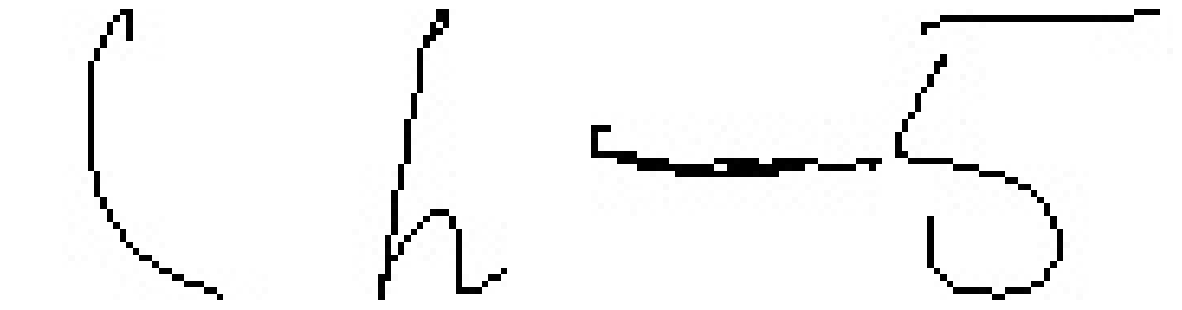

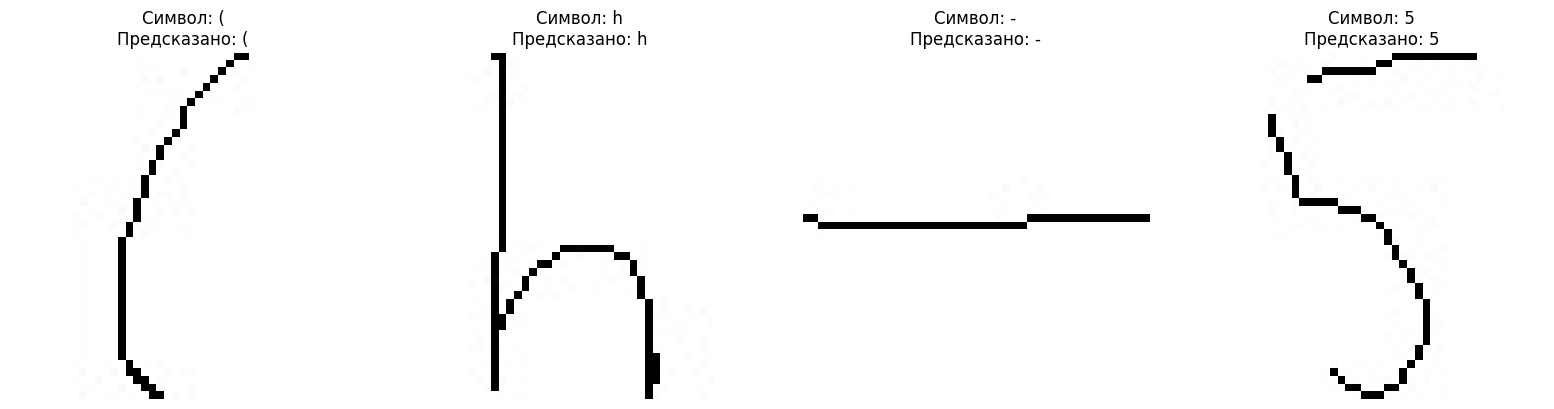


Распознанное выражение: (h-5

Проверка распознанного выражения:
Выражение корректно: (h-5
    Левый операнд: h
    Операция: -
    Правый операнд: 5

Сравнение результатов:
Исходное выражение: (h-5
Распознанное выражение: (h-5
Выражения совпадают


In [316]:
def check_expression_regex(expr):
    # Регулярное выражение для проверки формата:
    # ^ - начало строки
    # \(? - опциональная открывающая скобка
    # ([0-9hwXy]+) - первая группа: один или более символов из набора цифр, h, w, X, y
    # (\+|\-|times) - вторая группа: операция (+, - или times)
    # ([0-9hwXy]+) - третья группа: один или более символов из набора цифр, h, w, X, y
    # \)? - опциональная закрывающая скобка
    # $ - конец строки
    pattern = re.compile(r'^\(?([0-9hwXy]+)(\+|\-|times)([0-9hwXy]+)\)?$')
    match = pattern.match(expr)

    if match:
        groups = match.groups()
        print(f"Выражение корректно: {expr}")
        print(f"    Левый операнд: {groups[0]}")
        print(f"    Операция: {groups[1]}")
        print(f"    Правый операнд: {groups[2]}")
        return True
    else:
        print(f"Выражение не прошло проверку: {expr}")
        return False
# Пример использования:
expr = generate_expression()
expr_str = ''.join(expr)
print("Сгенерированное выражение:", expr_str)

# Проверяем корректность исходного выражения
print("\nПроверка исходного выражения:")
check_expression_regex(expr_str)

# Покажем изображение выражения
expr_img = generate_expression_with_images(expr)

# Классифицируем по символам
recognized_expr = classify_expression_image(knn_hog, expr)
print("\nРаспознанное выражение:", recognized_expr)

# Проверяем корректность распознанного выражения
print("\nПроверка распознанного выражения:")
check_expression_regex(recognized_expr)

# Сравниваем результаты
print("\nСравнение результатов:")
print(f"Исходное выражение: {expr_str}")
print(f"Распознанное выражение: {recognized_expr}")
print(f"Выражения {'совпадают' if expr_str == recognized_expr else 'не совпадают'}")

## g.	Если выражение корректно, вычислите результат, закодированный арифметическим выражением.

In [309]:
# Вывод последовательности
expression = ''.join(expr)
print("Сгенерированная последовательность символов:", expression)

# Проверка и вычисление результата
try:
    # Удаляем скобки если они есть
    clean_expression = expression.replace('(', '').replace(')', '')

    # Находим оператор
    for op in ['+', '-', '*', '/']:
        if op in clean_expression:
            break

    # Разделяем на операнды
    num1, num2 = clean_expression.split(op)
    num1 = int(num1.strip())  # Убираем возможные пробелы
    num2 = int(num2.strip())  # Убираем возможные пробелы

    # Выполняем операцию
    if op == '+':
        result = num1 + num2
    elif op == '-':
        result = num1 - num2
    elif op == '*':
        result = num1 * num2
    elif op == '/':
        result = num1 / num2

    print(f"Результат: {num1} {op} {num2} = {result}")
except Exception as e:
    print("Выражение некорректно или не может быть вычислено")
    print(f"Ошибка: {e}")


Сгенерированная последовательность символов: (4+8)
Результат: 4 + 8 = 12


# 2. Кодирование исходного сгенерированного файла

Сгенерированное выражение: 4times7)


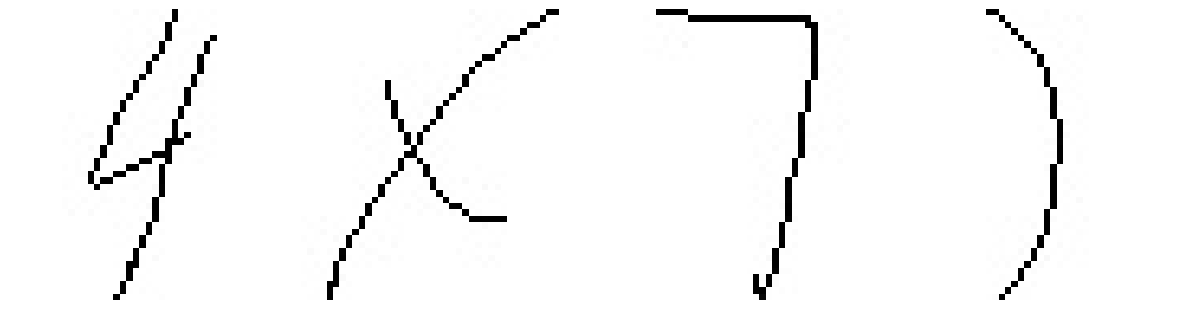

Изображение сохранено в saved_pic.png


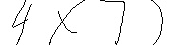

In [323]:
expr = generate_expression()
print(f"Сгенерированное выражение: {''.join(expr)}")
generate_expression_with_images(expr, 'saved_pic.png')

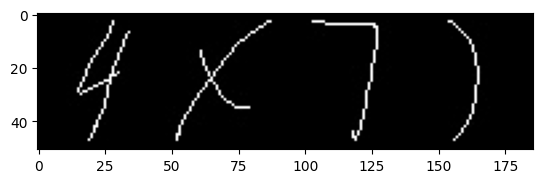

In [335]:
img = cv2.imread('saved_pic.png')

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel = np.ones((1,1),np.uint8)
img_gray = cv2.erode(img_gray,kernel,iterations = 1)
img_gray = cv2.bitwise_not(img_gray)
base_size=img_gray.shape[0]+6,img_gray.shape[1]+6
base=np.zeros(base_size,dtype=np.uint8)
base[3:img_gray.shape[0]+3,3:img_gray.shape[1]+3]=img_gray
base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

img_rgb = base

#img_rgb = cv2.bitwise_not(img_rgb)
plt.subplot(1, 1, 1)
plt.imshow(img_rgb)
plt.show()

(51, 186, 3)


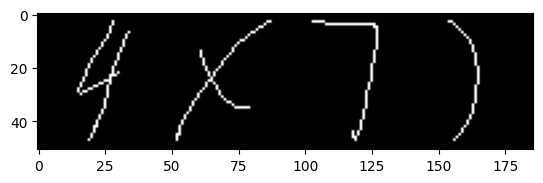

In [336]:
ret,thresh = cv2.threshold(img_rgb,127,255,0)
print(thresh.shape)
plt.subplot(1, 1, 1)
thresh = np.uint8(thresh)
plt.imshow(thresh)
plt.show()

[[154, 3, 12, 45], [103, 3, 25, 45], [52, 3, 36, 45], [15, 3, 20, 45]]


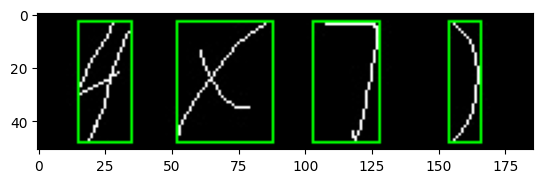

In [337]:
contours,h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
crops = []
for i in range(len(contours)):
    cnt = contours[i]
    area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    if w*h > 50:
        cv2.rectangle(img_rgb, (x,y), (x+w,y+h), (0,255,0), 1)  # BGR
        ret,thresh = cv2.threshold(img_gray[y:y+h, x:x+w], 127, 255, 0)
        crops.append([x,y,w,h])
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
print(crops)
plt.subplot(1, 1, 1)
plt.imshow(img_rgb)
plt.show()

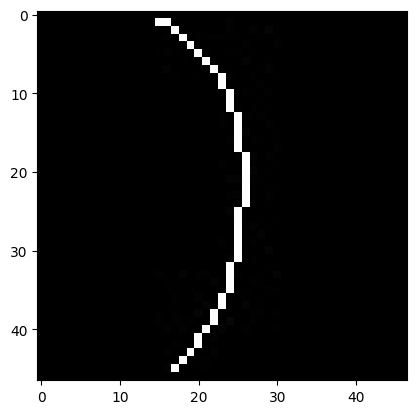

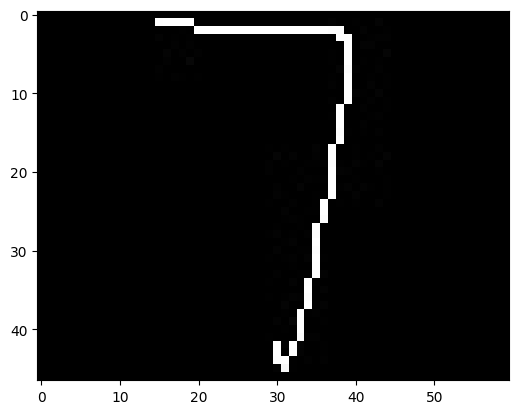

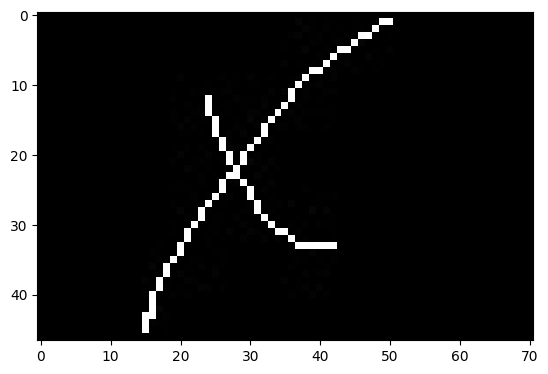

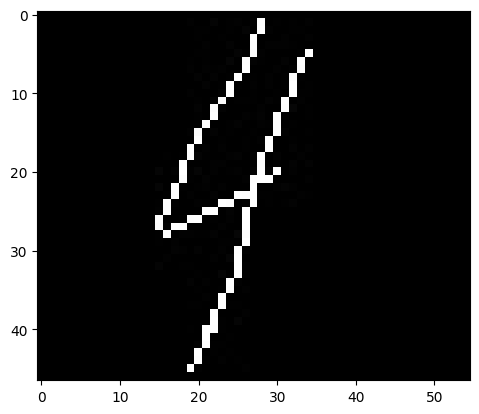

In [338]:
data_img= []
for i in range(len(crops)):
    x,y,w,h = crops[i]
    x-=3
    y-=3
    w+=5
    h+=3
    img = img_gray[y:y+h, x:x+w]
    base_size=img.shape[0]+2,img.shape[1]+30
    base=np.zeros(base_size,dtype=np.uint8)
    base[1:img.shape[0]+1,15:img.shape[1]+15]=img
    #plt.imshow(img_gray[y:y+h, x:x+w], cmap="gray")
    plt.imshow(base, cmap="gray")
    data_img.append((x,base))
    plt.show()

# Бинарная строка

Сгенерированное выражение: X-2


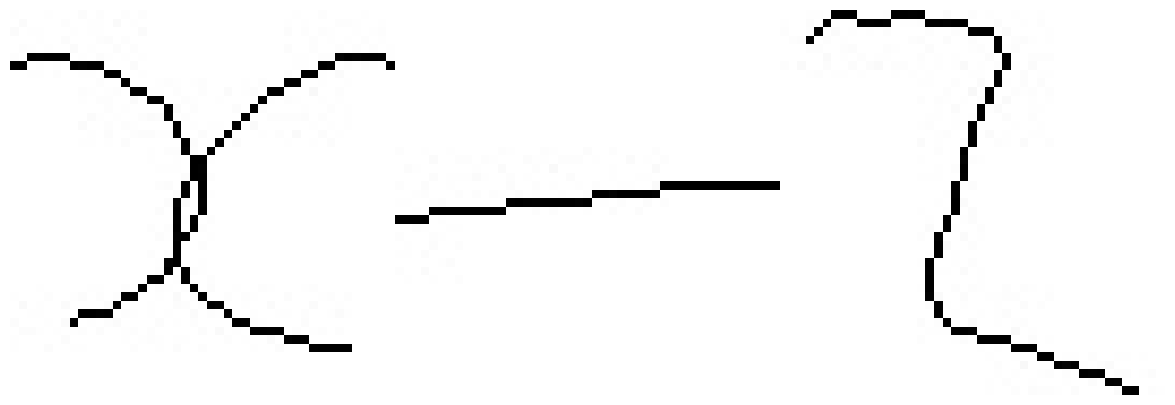

Изображение сохранено в saved_pic1.png
Бинарная строка для изображения:
1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001111000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101110000111100000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111100000111111111111111111111111111111100000011111111111111111111111111111111111111111111111111111111111111111111111101111111111111111110011111000011111111111111111111111110011111101111111111111111111111111111111111111111111111111111111111111111111111101

In [343]:
# Функция для преобразования изображения в бинарную строку
def image_to_binary_string(image):
    # Конвертируем PIL Image в numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
        # Если изображение RGB, конвертируем в градации серого
        if len(image_np.shape) == 3:
            gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        else:
            gray_image = image_np
    else:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применяем пороговое преобразование для получения бинарного изображения
    _, binary_image = cv2.threshold(gray_image, 128, 1, cv2.THRESH_BINARY)

    # Преобразуем массив в одномерный и создаем бинарную строку
    binary_string = ''.join(str(pixel) for pixel in binary_image.flatten())
    return binary_string

# Пример использования:
expr = generate_expression()
print(f"Сгенерированное выражение: {''.join(expr)}")
pic = generate_expression_with_images(expr, 'saved_pic1.png')

# Преобразуем объединенное изображение в бинарную строку
binary_string = image_to_binary_string(pic)

# Выводим бинарную строку
print(f"Бинарная строка для изображения:\n{binary_string}")